# 基于经典网络架构训练图像分类模型

### 数据预处理部分：

- 数据增强：torchvision中transforms模块自带功能，比较实用
- 数据预处理：torchvision中transforms也帮我们实现好了，直接调用即可
- DataLoader模块直接读取batch数据

### 网络模块设置：

- 加载预训练模型，torchvision中有很多经典网络架构，调用起来十分方便，并且可以用人家训练好的权重参数来继续训练，也就是所谓的迁移学习
- 需要注意的是别人训练好的任务跟咱们的可不是完全一样，需要把最后的head层改一改，一般也就是最后的全连接层，改成咱们自己的任务
- 训练时可以全部重头训练，也可以只训练最后咱们任务的层，因为前几层都是做特征提取的，本质任务目标是一致的

### 网络模型保存与测试
- 模型保存的时候可以带有选择性，例如在验证集中如果当前效果好则保存
- 读取模型进行实际测试

![title](1.png)

In [76]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
#https://pytorch.org/docs/stable/torchvision/index.html
import imageio
import time
import warnings
warnings.filterwarnings("ignore")
import random
import sys
import copy
import json
from PIL import Image

### 数据读取与预处理操作

In [77]:
data_dir = './flower_data/'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

### 数据预处理：
- data_transforms中指定了所有图像预处理操作
- ImageFolder假设所有的文件按文件夹保存好，每个文件夹下面存贮同一类别的图片，文件夹的名字为分类的名字

In [78]:
data_transforms = {
    'train': 
        # Compose: 按顺序进行操作
        transforms.Compose([
        transforms.Resize([96, 96]), # 截图太小容易丢失太多信息, 太大计算太慢
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(64),#从中心开始裁剪(缺胳膊少腿也能认出来)
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差 (使用大数据集算出来的数据)
    ]),
    'valid': # 验证集不需要增强
        transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 这里必须使用测试集的均值标准差, 不能使用验证集的, 否则就穿越了.
    ]),
}

In [79]:
batch_size = 128

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

In [99]:
dataloaders["train"].dataset

Dataset ImageFolder
    Number of datapoints: 6552
    Root location: ./flower_data/train
    StandardTransform
Transform: Compose(
               Resize(size=[96, 96], interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
               CenterCrop(size=(64, 64))
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
               RandomGrayscale(p=0.025)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

### 读取标签对应的实际名字

In [80]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [81]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

### 加载models中提供的模型，并且直接用训练的好权重当做初始化参数
- 第一次执行需要下载，可能会比较慢，我会提供给大家一份下载好的，可以直接放到相应路径

In [100]:
# 是否用GPU训练
# train_on_gpu = torch.cuda.is_available()
train_on_gpu = torch.backends.mps.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

CUDA is available!  Training on GPU ...


#### 模型参数要不要更新
- 有时候用人家模型，就一直用了，更不更新咱们可以自己定

In [82]:
model_name = 'resnet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']

In [84]:
#是否用人家训练好的参数来提取特征, 如果True, 表示不更新别人的参数
feature_extract = True

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [102]:
model_ft = models.resnet18()#18层的能快点，条件好点的也可以选152

'''
卷积得到的特征图, 如何过FC?

(avgpool): AdaptiveAvgPool2d(output_size=(1, 1)): 通过池化, 将特征图变成一个(1,1)的特征, 一般都是这个方式, 而不是把得到的特征图拉成一个长条reshape(batch_size, -1)
(fc): Linear(in_features=512, out_features=1000, bias=True)
'''
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 把模型输出层改成自己的

<img src="./img/model_fit_layers.png" width="70%">

In [104]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    
    model_ft = models.resnet18(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)

    # 修改model_fit的最后的全链接层, 修改输出位102分类
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)#重新构建一个全链接层, 覆盖原来的层, 类别数自己根据自己任务来
                            
    input_size = 64#输入大小根据自己配置来

    return model_ft, input_size

### 设置哪些层需要训练

In [105]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract=True, use_pretrained=True)

#GPU还是CPU计算
model_ft = model_ft.to(device)

# 模型保存，名字自己起
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 fc.weight
	 fc.bias


In [106]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 优化器设置

In [107]:
# 优化器设置
optimizer_ft = optim.Adam(params_to_update, lr=1e-2)#要训练啥参数，你来定
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
criterion = nn.CrossEntropyLoss()

### 训练模块

In [109]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25,filename='best.pt'):
    #咱们要算时间的
    since = time.time()
    #也要记录最好的那一次
    best_acc = 0
    #模型放到你的CPU或者GPU
    model.to(device)
    #训练过程中打印一堆损失和指标
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    #获取当前的学习率
    LRs = [optimizer.param_groups[0]['lr']]
    #最好的那次模型，后续会变的，先初始化
    best_model_wts = copy.deepcopy(model.state_dict()) # model.state_dict() 所有权重值w,b
    #一个个epoch来遍历
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)#放到你的CPU或GPU
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                # 训练阶段更新权重
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)#0表示batch那个维度
                running_corrects += torch.sum(preds == labels.data)#预测结果最大的和真实值是否一致
                
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)#算平均
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            time_elapsed = time.time() - since#一个epoch我浪费了多少时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),#字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                #scheduler.step(epoch_loss)#学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()
        scheduler.step()#学习率衰减(累加的)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

print("done")

done


In [115]:
model_fit.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221

### 开始训练！

- 我们现在只训练了输出层

In [91]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=20)

Epoch 0/19
----------


OverflowError: Python integer -20 out of bounds for uint8

### 再继续训练所有层

In [57]:
for param in model_ft.parameters():
    param.requires_grad = True

# 再继续训练所有的参数，学习率调小一点
optimizer = optim.Adam(model_ft.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 损失函数
criterion = nn.CrossEntropyLoss()

In [60]:
# 加载之前训练好的权重参数

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [61]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=10,)

Epoch 0/9
----------
Time elapsed 1m 32s
train Loss: 2.2451 Acc: 0.4846
Time elapsed 1m 36s
valid Loss: 2.3190 Acc: 0.4633
Optimizer learning rate : 0.0010000

Epoch 1/9
----------
Time elapsed 2m 54s
train Loss: 1.2920 Acc: 0.6505
Time elapsed 2m 58s
valid Loss: 2.2263 Acc: 0.4670
Optimizer learning rate : 0.0010000

Epoch 2/9
----------
Time elapsed 4m 15s
train Loss: 1.1026 Acc: 0.6993
Time elapsed 4m 19s
valid Loss: 1.8115 Acc: 0.5452
Optimizer learning rate : 0.0010000

Epoch 3/9
----------
Time elapsed 5m 35s
train Loss: 0.9062 Acc: 0.7515
Time elapsed 5m 39s
valid Loss: 2.0045 Acc: 0.5403
Optimizer learning rate : 0.0010000

Epoch 4/9
----------
Time elapsed 6m 56s
train Loss: 0.8392 Acc: 0.7643
Time elapsed 7m 0s
valid Loss: 2.1381 Acc: 0.5171
Optimizer learning rate : 0.0010000

Epoch 5/9
----------
Time elapsed 8m 17s
train Loss: 0.7081 Acc: 0.7953
Time elapsed 8m 21s
valid Loss: 2.0461 Acc: 0.5599
Optimizer learning rate : 0.0010000

Epoch 6/9
----------
Time elapsed 9m 38s


### 加载训练好的模型

In [62]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='best.pt'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

### 测试数据预处理

- 测试数据处理方法需要跟训练时一直才可以 
- crop操作的目的是保证输入的大小是一致的
- 标准化操作也是必须的，用跟训练数据相同的mean和std,但是需要注意一点训练数据是在0-1上进行标准化，所以测试数据也需要先归一化
- 最后一点，PyTorch中颜色通道是第一个维度，跟很多工具包都不一样，需要转换


In [98]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

output表示对一个batch中每一个数据得到其属于各个类别的可能性

In [99]:
output.shape

torch.Size([128, 102])

### 得到概率最大的那个

In [100]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([ 34,  49,  43,  54,  20,  14,  49,  43,  50,  20,  19, 100,  78,
        96,  96,  62,  62,  63,  32,  38,  82,  43,  88,  73,   6,  51,
        43,  89,  55,  75,  55,  11,  46,  82,  48,  82,  20, 100,  48,
        20,  24,  49,  76,  93,  49,  46,  90,  75,  89,  75,  76,  99,
        56,  48,  77,  66,  60,  72,  89,  97,  76,  73,  17,  48,  39,
        31,  19,  74,  61,  46,  93,  80,  27,  11,  91,  18,  23,  47,
        29,  54,  18,  93,   1,  50,  79,  96,  39,  53,  63,  60,  49,
        23,  23,  52,  99,  89,   3,  50,  64,  15,  19,  60,  19,  75,
        50,  78,  82,  18,  75,  18,  82,  53,   3,  52,  60,  38,  62,
        47,  21,  59,  81,  48,  89,  64,  60,  55, 100,  60], dtype=int64)

### 展示预测结果

In [101]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

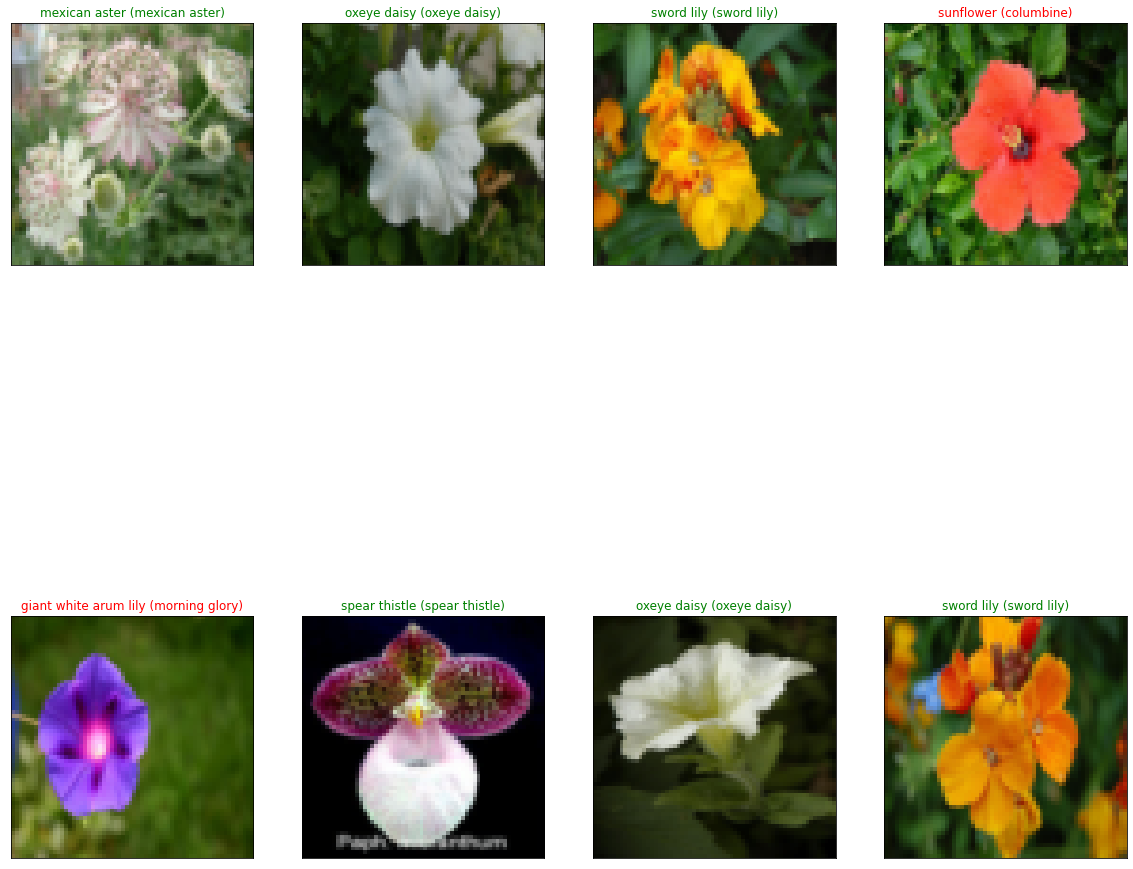

In [102]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]),
                 color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
plt.show()